In [34]:
pip install --upgrade -qq mplfinance

In [2]:
import copy
import datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mplfinance as mpf
import matplotlib.dates as mdates
from matplotlib.dates import (
    DateFormatter, WeekdayLocator, DayLocator, MONDAY
)
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
from sklearn.decomposition import PCA


In [3]:
df = pd.read_csv("/content/EURUSD_H1_202001020000_202404192300.csv",sep="\t")
df.index = pd.to_datetime(df["<DATE>"] + " " + df["<TIME>"])
def col_map(x):
  return x[1:-1].capitalize()
df.rename(columns=col_map, inplace=True)
df.drop(columns=["Date", "Time","Tickvol","Vol","Spread"], inplace=True)
df

,Open,High,Low,Close
2020-01-02 00:00:00,1.12119,1.12159,1.12081,1.12147
2020-01-02 01:00:00,1.12147,1.12220,1.12146,1.12188
2020-01-02 02:00:00,1.12188,1.12192,1.12156,1.12183
2020-01-02 03:00:00,1.12183,1.12245,1.12181,1.12210
2020-01-02 04:00:00,1.12209,1.12246,1.12184,1.12224
...,...,...,...,...
2024-04-19 19:00:00,1.06550,1.06597,1.06403,1.06536
2024-04-19 20:00:00,1.06536,1.06586,1.06510,1.06559
2024-04-19 21:00:00,1.06558,1.06558,1.06466,1.06507
2024-04-19 22:00:00,1.06507,1.06555,1.06498,1.06548


In [12]:
def features(df):
    df = df.copy()
    df['Body Size'] = (df['Close'] - df['Open']).abs()
    df['Upper Shadow Size'] = df.apply(lambda x: (x['High'] - x['Close']) if x['Close'] > x['Open'] else (x['High'] - x['Open']), axis=1)
    df['Lower Shadow Size'] = df.apply(lambda x: (x['Open'] - x['Low']) if x['Close'] > x['Open'] else (x['Close'] - x['Low']), axis=1)
    df['Candle Direction'] = (df['Close'] > df['Open']).astype(int)
    # Calculate Relative Position of Close
    df['Relative Position of Close'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])

    # Calculate Body Percentage as a percentage of the entire range of the candle
    df['Body Percentage'] = df['Body Size'] / (df['High'] - df['Low'])

    # Calculate Upper to Lower Shadow Ratio
    df['Upper to Lower Shadow Ratio'] = df['Upper Shadow Size'] / df['Lower Shadow Size'].replace(0, np.nan)

    # Cap Upper to Lower Shadow Ratio to a maximum value (10 in this case)
    max_ratio = 10
    df['Upper to Lower Shadow Ratio'] = df['Upper to Lower Shadow Ratio'].clip(upper=max_ratio)

    # Apply log transformation to Upper to Lower Shadow Ratio
    df['Upper to Lower Shadow Ratio'] = np.log1p(df['Upper to Lower Shadow Ratio'])

    # Fill missing values and drop unnecessary columns
    df.fillna(0, inplace=True)
    df.drop(['Open', 'High', 'Low', 'Close', 'Body Size', 'Upper Shadow Size', 'Lower Shadow Size'], axis=1, inplace=True)

    return df

In [13]:
fe = features(df)

In [18]:
fe

,Cluster,Candle Direction,Relative Position of Close,Body Percentage,Upper to Lower Shadow Ratio
2020-01-02 00:00:00,119,1,0.846154,0.358974,0.274437
2020-01-02 01:00:00,18,1,0.567568,0.554054,2.397895
2020-01-02 02:00:00,96,0,0.750000,0.138889,0.138150
2020-01-02 03:00:00,49,1,0.453125,0.421875,2.397895
2020-01-02 04:00:00,23,1,0.645161,0.241935,0.631272
...,...,...,...,...,...
2024-04-19 19:00:00,1,0,0.685567,0.072165,0.302608
2024-04-19 20:00:00,23,1,0.644737,0.302632,0.712195
2024-04-19 21:00:00,28,0,0.445652,0.554348,0.000000
2024-04-19 22:00:00,31,1,0.877193,0.719298,0.575364


In [33]:
# Filter out unnecessary columns
included_columns = fe.filter(regex='(?i)cluster').columns
filtered_columns = fe.columns.difference(included_columns)
fe = fe[filtered_columns]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


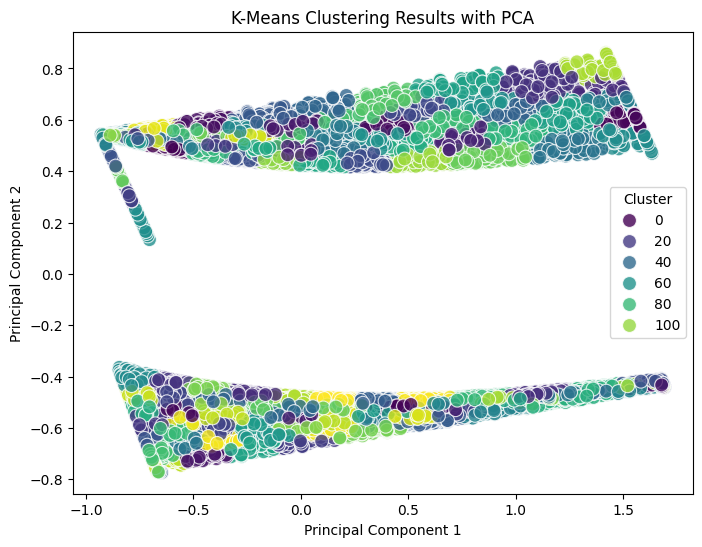

In [25]:
# K-Means Clustering
kmeans = KMeans(n_clusters=120, random_state=42)  # 120 is best choice so far
df['Cluster'] = kmeans.fit_predict(fe[fe.columns[:]])  # Fit and predict

# PCA for Dimensionality Reduction for Visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(fe[fe.columns[:]])

# Scatter Plot of the Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=df['Cluster'], palette="viridis", s=100, alpha=0.8).set(title='K-Means Clustering Results with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

<Axes: xlabel='Cluster'>

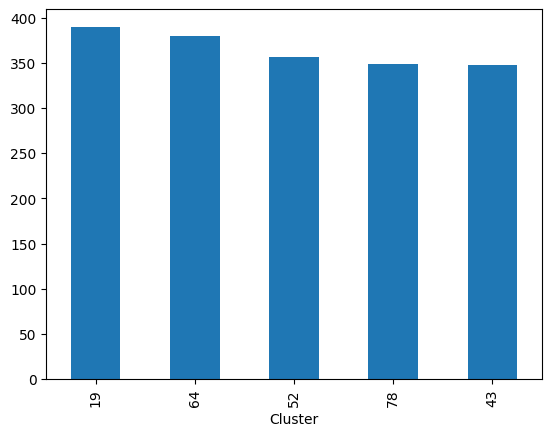

In [38]:
# Plot the clusters value counts sorted
# sns.countplot(x='Cluster', data=df)
df['Cluster'].value_counts()[:5].plot(kind='bar')

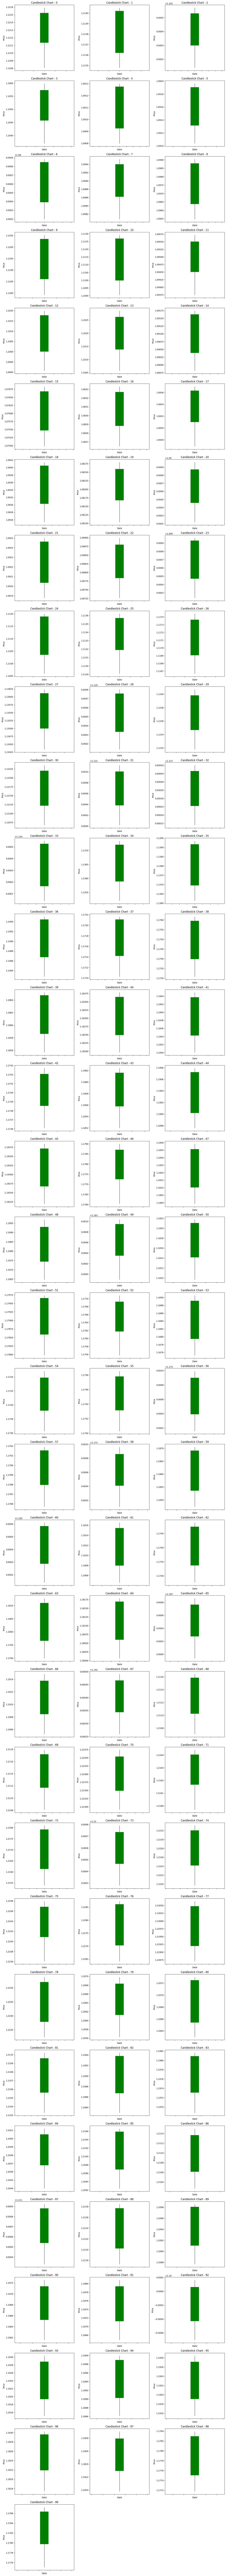

In [41]:
df_ = df[df['Cluster'] == 43].reset_index(drop=True)[:100]

num_columns = 3

# Calculate the number of rows needed to accommodate all the charts
num_rows = (len(df_) + num_columns - 1) // num_columns

# Create a new figure for the table
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Iterate through each row of the DataFrame
for idx, (index, row) in enumerate(df_.iterrows()):
    # Calculate the row and column indices for the current subplot
    row_idx = idx // num_columns
    col_idx = idx % num_columns

    # Create a subplot for the current candlestick
    ax = axs[row_idx, col_idx] if num_rows > 1 else axs[col_idx]

    # Plot the candlestick for the current row
    ax.plot([index, index], [row['Low'], row['High']], color='black', linewidth=1)
    ax.plot([index, index], [row['Open'], row['Close']], color='red' if row['Close'] < row['Open'] else 'green', linewidth=40)

    # Set the title and labels
    ax.set_title(f'Candlestick Chart - {index}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # Remove x-axis ticks and labels
    ax.xaxis.set_tick_params(rotation=45)
    ax.xaxis.set_ticklabels([])

# Hide any unused subplots
for idx in range(len(df_), num_rows * num_columns):
    row_idx = idx // num_columns
    col_idx = idx % num_columns
    axs[row_idx, col_idx].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

In [42]:
df

,Open,High,Low,Close,Cluster
2020-01-02 00:00:00,1.12119,1.12159,1.12081,1.12147,43
2020-01-02 01:00:00,1.12147,1.12220,1.12146,1.12188,50
2020-01-02 02:00:00,1.12188,1.12192,1.12156,1.12183,18
2020-01-02 03:00:00,1.12183,1.12245,1.12181,1.12210,2
2020-01-02 04:00:00,1.12209,1.12246,1.12184,1.12224,72
...,...,...,...,...,...
2024-04-19 19:00:00,1.06550,1.06597,1.06403,1.06536,95
2024-04-19 20:00:00,1.06536,1.06586,1.06510,1.06559,72
2024-04-19 21:00:00,1.06558,1.06558,1.06466,1.06507,19
2024-04-19 22:00:00,1.06507,1.06555,1.06498,1.06548,56


In [43]:
df["Label"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

In [44]:
df

,Open,High,Low,Close,Cluster,Label
2020-01-02 00:00:00,1.12119,1.12159,1.12081,1.12147,43,1
2020-01-02 01:00:00,1.12147,1.12220,1.12146,1.12188,50,0
2020-01-02 02:00:00,1.12188,1.12192,1.12156,1.12183,18,1
2020-01-02 03:00:00,1.12183,1.12245,1.12181,1.12210,2,1
2020-01-02 04:00:00,1.12209,1.12246,1.12184,1.12224,72,0
...,...,...,...,...,...,...
2024-04-19 19:00:00,1.06550,1.06597,1.06403,1.06536,95,1
2024-04-19 20:00:00,1.06536,1.06586,1.06510,1.06559,72,0
2024-04-19 21:00:00,1.06558,1.06558,1.06466,1.06507,19,1
2024-04-19 22:00:00,1.06507,1.06555,1.06498,1.06548,56,1


In [50]:
df['Cluster'].values


array([43, 50, 18, ..., 19, 56, 72], dtype=int32)

In [ ]:
# Create an embedding layer
embedding_dim = 10
embedding_layer = Embedding(input_dim=max(cluster_values_int) + 1, output_dim=embedding_dim, input_length=1)

# Convert the cluster values to an embedded tensor
embedded_clusters = embedding_layer(cluster_values_int.reshape(-1, 1))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator

# Normalize the cluster values
# scaler = MinMaxScaler()
cluster_values = df['Cluster'].values

# Create an embedding layer
embedding_dim = 10
embedding_layer = Embedding(input_dim=max(cluster_values) + 1, output_dim=embedding_dim, input_length=1)

# Convert the cluster values to an embedded tensor
embedded_clusters = embedding_layer(cluster_values.reshape(-1, 1))
embedded_clusters = np.squeeze(embedded_clusters)
# Create an LSTM model
seq_len = 10  # sequence length
batch_size = 32  # batch size
lstm_units = 50  # LSTM units

model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(seq_len, embedding_dim)))
model.add(LSTM(units=lstm_units))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create a timeseries generator
generator = TimeseriesGenerator(embedded_clusters, df["Label"].values.reshape(-1, 1), length=seq_len, batch_size=batch_size)

# Train the model
model.fit(generator, epochs=50)

# Make predictions
predictions = model.predict(generator)

# Evaluate the model
mse = model.evaluate(generator)
print(f'MSE: {mse:.2f}')

Epoch 1/50
837/837 [==============================] - 22s 17ms/step - loss: 0.6933 - accuracy: 0.5006
Epoch 2/50
231/837 [=======>......................] - ETA: 8s - loss: 0.6930 - accuracy: 0.5083